This Python Notebook gathers the steps taken to come up with a supervised classification model able to forecast the result of real estate auctions in Italy given both exogenous features (e.g. the minimum bid price) and, more importantly, endogenous features (e.g. the number of online visits that a listing gets within 7 days of pubblication on real estate portals).

#Mount Google Drive

In [0]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Statements

In [0]:
import glob
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, \
                            classification_report, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
pd.options.mode.chained_assignment = None
np.random.seed(1234)

In [0]:
path = r'/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/'
filenames = glob.glob(os.path.join(path, "FOGLIO UNICO - Vivacizzazione *.xlsx"))

In [0]:
filenames

['/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20190201.xlsx',
 '/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20200131.xlsx',
 '/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20190215.xlsx',
 '/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20190301.xlsx',
 '/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20190401.xlsx',
 '/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20190502.xlsx',
 '/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20190601.xlsx',
 '/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20190701.xlsx',
 '/content/drive/My Drive/Colab Notebooks/Data/Foglio Unico/FOGLIO UNICO - Vivacizzazione - 20190702.xlsx',
 '/content/drive/My Drive/Co

In [0]:
df_raw = pd.concat((pd.read_excel(f) for f in filenames), sort = True)

In [0]:
df_raw.shape

(39509, 103)

# Feature Preparation

## An initial glance at data

In [0]:
df = df_raw.copy()

In [0]:
df.head()

,Aggiudicata dal Cliente?,Anno asta,Asta Passata?,CHECK DATA,CHECK ESPERIMENTO,CHECK LINK,CHECK LOTTO,CHECK PREZZO BASE,CHECK RGE,CHECK TRIBUNALE,CTU,Check,Check Esiti Positivi vs Interessati,Clienti a Visita,Comune,Conformità,Custode,DATA PUBBLICAZIONE,Da caricare su Getrix?,Da charicare?,Data asta,Data pubblicazione su Getrix,Data sopralluogo,Delegato,Esito,Esito Negativo,Esito Positivo,Focus Venditore,GESTORE,Garantito,Getrix (ST),Id Immobile,Immobili all'Asta?,In provincia?,Indirizzo,Interessati,Link,Link Immobiliare.it,Link Pubblicità,Link Tribunale,...,Numero telefonate outbound,Numero telefonate/mail ricevute,Numero totale partecipanti,Occupato/Libero/Con contratto,Offerta minima,P(Agg),P(Aggiudicazione),Premium,Prezzo base,Prezzo di aggiudicazione,Provincia,Qualità Annuncio (%),RGE,RIF.,Regione,Risparmio,SERVICER,ST,STATO AGGIORNAMENTO,Salvati dopo 7 gg,Sconto,Settimana asta,Sistemia Secret?,Soldi Guadagnati,Soldi Persi Partner €,Soldi persi LF,Star,Stato,TOTALE VIEWS,TOTALE VISITE,Tipologia,Tipologia Clienti Offerenti,Top,Tribunale,VENETO - Da caricare?,Valutazione,Venditore,Vetrina,Visibilità\nPartner,Visite dopo 7 gg
0,NaN,2018.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-09,NaT,NaN,NaN,NaN,NaN,NaN,NaN,SISTEMIA,NaN,NaN,1,NaN,Si,"Via Alessandria, FERENTILLO (TR)",NaN,https://pvp.giustizia.it/pvp/it/dettaglio_annu...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,62437,NaN,NaN,NaN,NaN,NaN,TR,NaN,4/2013,2334.0,UMBRIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deserta,NaN,NaN,NaN,NaN,NaN,TERNI,NaN,NaN,NaN,NaN,0.0,NaN
1,NaN,2018.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,SISTEMIA,NaN,NaN,2,NaN,No,"VIA GAETANO MAZZONI 38, ROMA (RM)",NaN,https://www.astegiudiziarie.it/vendita-asta-ap...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,28725,NaN,NaN,NaN,NaN,NaN,RM,NaN,1426/2014,NaN,LAZIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deserta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,NaN,2018.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,SISTEMIA,NaN,NaN,NaN,NaN,No,"VIA GIOVENALE ANCINA, TORINO (TO)",NaN,http://www.tribunale.torino.giustizia.it/it/As...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,42750,NaN,NaN,NaN,NaN,NaN,TO,NaN,477/2016,NaN,PIEMONTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deserta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,NaN,2018.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,SISTEMIA,NaN,NaN,NaN,NaN,Si,"VIA D'ANNUNZIO GABRIELE, GIOIA DEL COLLE (BA)",NaN,https://www.astegiudiziarie.it/vendita-asta-ap...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,41343.8,NaN,NaN,NaN,NaN,NaN,BA,NaN,1013/2014,NaN,PUGLIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deserta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,NaN,2018.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-11,NaT,NaN,NaN,NaN,NaN,NaN,NaN,SISTEMIA,NaN,NaN,NaN,NaN,Si,"Via XXV Aprile, RONCO SCRIVIA (GE)",NaN,https://www.astegiudiziarie.it/vendita-asta-ap...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,60000,NaN,NaN,NaN,NaN,NaN,GE,NaN,7/2017,NaN,LIGURIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deserta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [0]:
df.isna().sum()

Aggiudicata dal Cliente?    37420
Anno asta                    7914
Asta Passata?                7914
CHECK DATA                  36061
CHECK ESPERIMENTO           37062
                            ...  
Valutazione                 17612
Venditore                   38552
Vetrina                     39077
Visibilità\nPartner         32100
Visite dopo 7 gg            29404
Length: 103, dtype: int64

## Filter columns

Select only columns of interest:
*   'Id Immobile' = an id representing the real estate asset on auction
*   'DATA PUBBLICAZIONE' = the date of our pubblication of the auction on real estate portals
*   'Views dopo 7 gg' = the number of online views of our auction listing on real estate portals after 7 days of pubblication
*   'Offerta minima' = the minimum bid to join the auction
*   'Valutazione' = our homemade evaluation of the real estate asset (made with proprietary sotfware and algorithms)
*   'NTN RES' = number of last-year residential transactions of the city where the real estate asset is located
*   'Esito' = the auction result

In [0]:
df = df[['Id Immobile', 'DATA PUBBLICAZIONE', 'Visite dopo 7 gg', 'Offerta minima', 'Valutazione', 'NTN RES', 'Esito']]

In [0]:
print("Percentage of null 'Id Immobili': {0:.2f}%".format(100 * df['Id Immobile'].isnull().sum() / df['Id Immobile'].shape[0]))
print("Number of auctions with no 'Visite dopo 7 giorni': {:,}".format(df['Visite dopo 7 gg'].isnull().sum()))
print("Number of auctions with no 'Esito': {:,}".format(df['Esito'].isnull().sum()))

Percentage of null 'Id Immobili': 48.87%
Number of auctions with no 'Visite dopo 7 giorni': 29,404
Number of auctions with no 'Esito': 26,778


In [0]:
print("Number or rows in dataframe: {:,}".format(df.shape[0]))
print('Numero di colonne del dataframe: {:,}'.format(df.shape[1]))

Number or rows in dataframe: 39,509
Numero di colonne del dataframe: 7


## Pre-Processing

Now let's drop:
*   null 'Esito'
*   null 'Views dopo 7 gg'
*   null 'Offerta minima'
*   null 'Valutazione'
*   null 'NTN RES'
*   null 'Id Immobile'
*   duplicated combinations of 'Id Immobile' and 'Data Pubblicazione'

In [0]:
df.dropna(subset=['Esito', 'Visite dopo 7 gg', 'Offerta minima', 'Valutazione', 'NTN RES', 'Id Immobile'], how='any', inplace=True)

In [0]:
df.drop_duplicates(subset=['Id Immobile', 'DATA PUBBLICAZIONE'], keep='last', inplace=True)

Kepp only auctions with 'Esito' equal to 'Deserta' or 'Aggiudicata'

In [0]:
df = df.loc[df['Esito'].isin(['Deserta', 'Aggiudicata'])]

Kepp only auctions with valid 'Valutazione'

In [0]:
df = df.loc[df['Valutazione'] != '-']

Convert to numeric all numeric features

In [0]:
numeric_columns = ['Offerta minima', 'Valutazione']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

Add 'Sconto' as the discount of 'Offerta Minima' with respect to 'Valutazione'


In [0]:
df['Sconto'] = pd.to_numeric((df['Valutazione'] - df['Offerta minima']) / df['Valutazione'])
df = df.loc[~np.log(df['Offerta minima'] + 1).isnull()]
df.reset_index(inplace=True, drop=True)

One-Hot Encoding of label (target) variable 'Esito'

In [0]:
df['Esito'] = df['Esito'].apply(lambda x: 1 if x == 'Aggiudicata' else 0)

## Normalization

Let's transform 'Offerta minima', 'Visite dopo 7 gg', and 'NTN RES' for better model performance

In [0]:
log = True
standard = False

if log:
  df['offerta_minima'] = np.log(df['Offerta minima'] + 1)
  df['views'] = np.log(df['Visite dopo 7 gg'] + 1)
  df['ntn'] = np.log(df['NTN RES'] + 1)

if standard:
  sc = StandardScaler()
  df['sconto'] = sc.fit_transform(np.array(df['Sconto']).reshape(-1, 1))
  df['offerta_minima'] = sc.fit_transform(np.array(df['Offerta minima']).reshape(-1, 1))
  df['views'] = sc.fit_transform(np.array(df['Visite dopo 7 gg']).reshape(-1, 1))

## Sanity check

In [0]:
print("Number of rows in dataframe: {:,}".format(df.shape[0]))
print("Number of columns in dataframe: {:,}".format(df.shape[1]))

Number of rows in dataframe: 1,031
Number of columns in dataframe: 11


In [0]:
df.iloc[[100, 145, 257], ]

,Id Immobile,DATA PUBBLICAZIONE,Visite dopo 7 gg,Offerta minima,Valutazione,NTN RES,Esito,Sconto,offerta_minima,views,ntn
100,20897,NaT,114.0,25312.5,52113.6,144.20,1,0.514282,10.139093,4.744932,4.978112
145,78559,2019-02-04,251.0,50017.5,150052.5,757.47,1,0.666667,10.820148,5.529429,6.631303
257,101773,2019-04-24,72.0,55000.0,106145.6,25.25,0,0.481844,10.915107,4.290459,3.267666


In [0]:
print("Number of auctions with null 'Visite dopo 7 gg': {:,}".format(df['Visite dopo 7 gg'].isnull().sum()))
print("Number of auctions with null 'Esito': {:,}".format(df['Esito'].isnull().sum()))
print("Number of auctions with null 'Id Immobile': {:,}".format(df['Id Immobile'].isnull().sum()))
print("Number of auctions with null 'Offerta minima': {:,}".format(df['Offerta minima'].isnull().sum()))
print("Number of auctions with null 'Valutazione': {:,}".format(df['Valutazione'].isnull().sum()))

Number of auctions with null 'Visite dopo 7 gg': 0
Number of auctions with null 'Esito': 0
Number of auctions with null 'Id Immobile': 0
Number of auctions with null 'Offerta minima': 0
Number of auctions with null 'Valutazione': 0


## Check Class Balance

In [0]:
num_aggiudicate = df['Esito'].loc[df['Esito']==1].shape[0]
num_deserte = df['Esito'].loc[df['Esito']==0].shape[0]
num_tot = df['Esito'].shape[0]

In [0]:
print("Percentage of auctions being 'Aggiudicata': {0:.2f}%".format(100 * num_aggiudicate / num_tot))
print("Percentage of auctions being 'Deserta': {0:.2f}%".format(100 * num_deserte / num_tot))

Percentage of auctions being 'Aggiudicata': 55.97%
Percentage of auctions being 'Deserta': 44.03%


Class 'Esito' is adequatly balanced (almost 50-50)

#Exploratory Data Analysis

## Boxplot of log('Visite dopo 7 gg') by 'Esito'

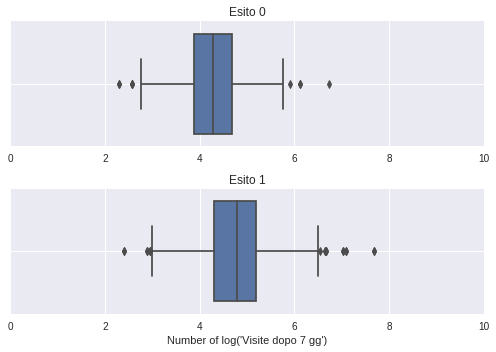

In [0]:
fig = plt.figure(figsize = (7, 5))
esito = [None, 0, 1]
for i in range(1, 3):
    ax = fig.add_subplot(2, 1, i)
    sns.boxplot(data=df.loc[df['Esito'] == esito[i]], x='views')
    ax.set(xlabel = '',
       title=f'Esito {esito[i]}',
       xlim = (0, 10)
    )
    ax.grid(True)

plt.xlabel("Number of log('Visite dopo 7 gg')")
plt.tight_layout()
plt.savefig("Boxplot of log('Visite dopo 7 gg') by 'Esito'")

## Distribution of Visite dopo 7 gg' by 'Esito'

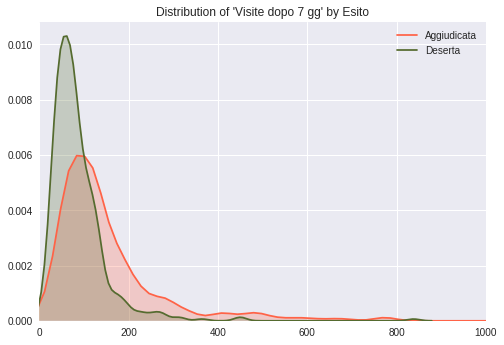

In [0]:
fig, ax = plt.subplots()
ax = sns.kdeplot(df.loc[df['Esito']==1 , 'Visite dopo 7 gg'],
            color='tomato',
            shade=True,
            Label='Aggiudicata')

ax = sns.kdeplot(df.loc[df['Esito']==0 , 'Visite dopo 7 gg'],
            color='darkolivegreen',
            shade=True,
            Label='Deserta')

_ = ax.set(title="Distribution of 'Visite dopo 7 gg' by Esito",
           xlim = (0, 1000))
ax.grid(True)
plt.savefig("Distribution of 'Visite dopo 7 gg' by 'Esito'")

## Distribution of log('NTN') by 'Esito'

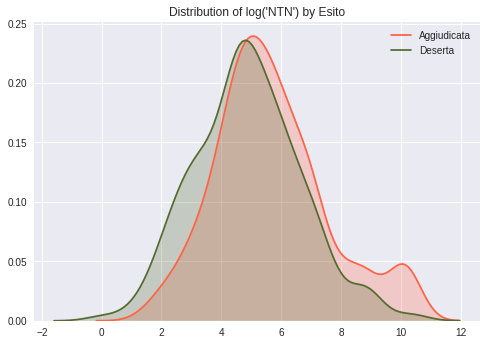

In [0]:
fig, ax = plt.subplots()
ax = sns.kdeplot(df.loc[df['Esito']==1 , 'ntn'],
            color='tomato',
            shade=True,
            Label='Aggiudicata')

ax = sns.kdeplot(df.loc[df['Esito']==0 , 'ntn'],
            color='darkolivegreen',
            shade=True,
            Label='Deserta')

_ = ax.set(title="Distribution of log('NTN') by Esito")
ax.grid(True)
plt.savefig("Distribution of log('NTN') by 'Esito'")

## Distribution of 'Sconto' by 'Esito'

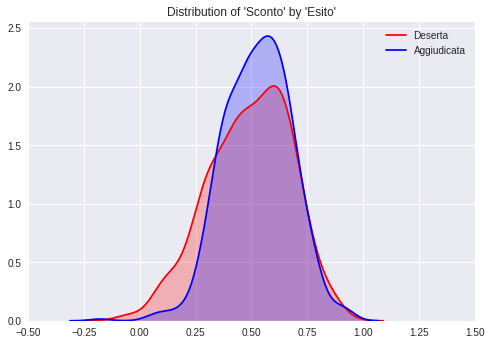

In [0]:
fig, ax = plt.subplots()
ax = sns.kdeplot(df.loc[df['Esito']==0 , 'Sconto'],
            color='r',
            shade=True,
            Label='Deserta')

ax = sns.kdeplot(df.loc[df['Esito']==1 , 'Sconto'],
            color='b',
            shade=True,
            Label='Aggiudicata')

_ = ax.set(title="Distribution of 'Sconto' by 'Esito'",
           xlim = (-0.5, 1.5))
ax.grid(True)
plt.savefig("Distribution of 'Sconto' by 'Esito'")

## Distribution of log('Offerta Minima) by 'Esito'

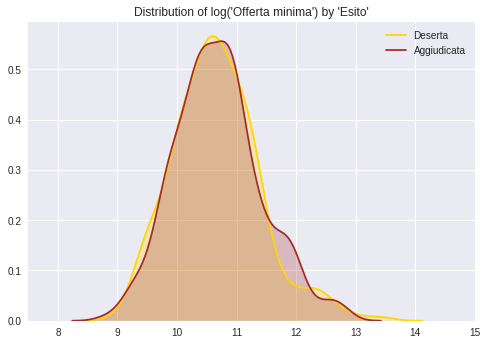

In [0]:
fig, ax = plt.subplots()
ax = sns.kdeplot(df.loc[df['Esito']==0 , 'offerta_minima'],
            color='gold',
            shade=True,
            Label='Deserta')

ax = sns.kdeplot(df.loc[df['Esito']==1 , 'offerta_minima'],
            color='brown',
            shade=True,
            Label='Aggiudicata')

_ = ax.set(title="Distribution of log('Offerta minima') by 'Esito'",
           xlim = (7.5, 15))
ax.grid(True)
plt.savefig("Distribution of log('Offerta minima') by 'Esito'")

## Distribution of 'Valutazione' by 'Esito'

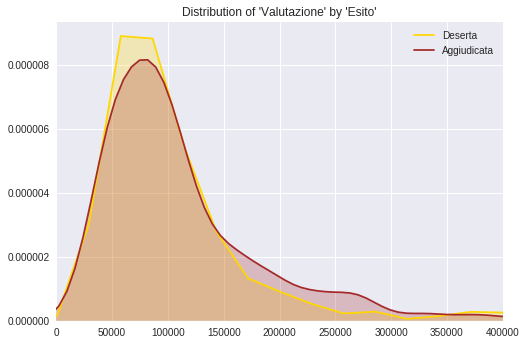

In [0]:
fig, ax = plt.subplots()
ax = sns.kdeplot(df.loc[df['Esito']==0, 'Valutazione'],
            color='gold',
            shade=True,
            Label='Deserta')

ax = sns.kdeplot(df.loc[df['Esito']==1, 'Valutazione'],
            color='brown',
            shade=True,
            Label='Aggiudicata')

_ = ax.set(title="Distribution of 'Valutazione' by 'Esito'",
           xlim = (0, 4e5))
ax.grid(True)
plt.savefig("Distribution of 'Valutazione' by 'Esito'")

## Correlation Matrix

Text(0.5, 1, 'Heatmap of Correlation Matrix')

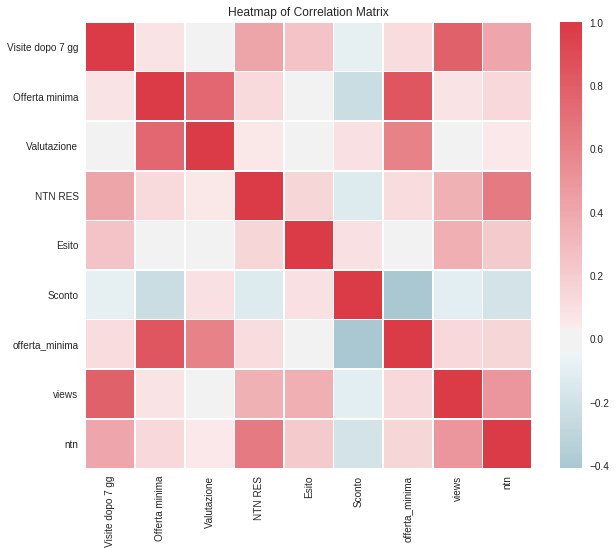

In [0]:
corr_matrix = df.corr()

# Heatmap
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# deep dive into diverging_pattern
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns.values,
           yticklabels=corr_matrix.columns.values, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

#Machine Learning

In [0]:
df.drop(['Id Immobile','DATA PUBBLICAZIONE', 'Offerta minima', 'Visite dopo 7 gg', 'Valutazione', 'NTN RES'], axis=1, inplace=True)

In [0]:
df.head()

,Esito,Sconto,offerta_minima,views,ntn
0,0,0.297500,11.054471,4.543295,4.306360
1,1,0.498077,11.085997,4.844187,5.332429
2,1,0.526316,9.798183,4.406719,5.928844
3,0,0.616949,10.025749,4.290459,6.094563
4,1,0.437500,10.426765,5.267858,6.929781


In [0]:
def learning_curves(model, X_train, y_train):
    x_train, x_val, ytrain, yval = train_test_split(X_train, y_train, test_size=0.35, random_state=0)

    training_score = []
    test_score = []
    for i in range(10, len(X_train), 5):
        model.fit(x_train[:i], ytrain[:i])
        y_pred_train = model.predict(x_train[:i])
        y_pred_val = model.predict(x_val)
        training_score.append(accuracy_score(y_pred_train, ytrain[:i]))
        test_score.append(accuracy_score(y_pred_val, yval))
    sns.lineplot(x = [i for i in range(len(training_score))], y = training_score, label = 'TRAINING SET')
    sns.lineplot(x = [i for i in range(len(test_score))], y = test_score, label = 'VALIDATION SET')
    plt.legend()
    plt.show()
    print(f'The accuracy is {test_score[-1]}')

X = df.drop(['Esito'], axis=1).values

y = df['Esito'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)

## Logistic Regression Model

###Hyperparameters Optimization

In [0]:
hyper_lr = {'C' : [0.01, 0.03, 0.07, 0.1, 0.3, 0.5, 0.7, 1],
            'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'penalty': ['l1', 'l2']}

In [0]:
gs = GridSearchCV(LogisticRegression(max_iter=10000), hyper_lr, cv = 4, scoring = 'accuracy')
gs.fit(X_train, y_train)
best_parameters_lr = gs.best_params_
print(best_parameters_lr)

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


### Fit

In [0]:
model_lr= LogisticRegression(penalty=best_parameters_lr['penalty'], max_iter=10000, C=best_parameters_lr['C'], solver=best_parameters_lr['solver'])

model_lr.fit(X_train, y_train)

predictions_lr = model_lr.predict(X_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions_lr, y_test)))
print(confusion_matrix(predictions_lr, y_test))
tp, fp, fn, tn = confusion_matrix(predictions_lr, y_test).ravel()
print(f"tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}")
print(classification_report(y_test, predictions_lr))

Accuracy 63.99%
[[ 75  35]
 [ 95 156]]
tp: 75, fp: 35, fn: 95, tn: 156
              precision    recall  f1-score   support

           0       0.68      0.44      0.54       170
           1       0.62      0.82      0.71       191

    accuracy                           0.64       361
   macro avg       0.65      0.63      0.62       361
weighted avg       0.65      0.64      0.63       361



### Learning curve

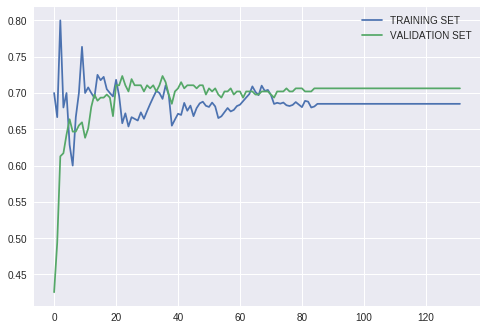

The accuracy is 0.7063829787234043


In [0]:
learning_curves(model_lr, X_train, y_train)

## Random Forest

### Hyperparameters optimization

In [0]:
hyper_rf = {'n_estimators': [100, 150, 200],
            'min_samples_split': [20, 30],
            'max_leaf_nodes': [100, 200]}

In [0]:
gs = GridSearchCV(RandomForestClassifier(), hyper_rf, iid=False, cv=4,
                  scoring='accuracy', return_train_score=False)
gs.fit(X_train, y_train)
best_parameters_rf = gs.best_params_
print(best_parameters_rf)

{'max_leaf_nodes': 100, 'min_samples_split': 20, 'n_estimators': 150}


###Fit

In [0]:
model_rf = RandomForestClassifier(n_estimators= best_parameters_rf['n_estimators'],
                                  min_samples_split=best_parameters_rf['min_samples_split'],
                                  max_leaf_nodes =best_parameters_rf['max_leaf_nodes'])
model_rf.fit(X_train, y_train)

predictions_rf = model_rf.predict(X_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions_rf, y_test)))
print(confusion_matrix(predictions_rf, y_test))
tp, fp, fn, tn = confusion_matrix(predictions_rf, y_test).ravel()
print(f"tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}")
print(classification_report(y_test, predictions_rf))

Accuracy 69.25%
[[100  41]
 [ 70 150]]
tp: 100, fp: 41, fn: 70, tn: 150
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       170
           1       0.68      0.79      0.73       191

    accuracy                           0.69       361
   macro avg       0.70      0.69      0.69       361
weighted avg       0.69      0.69      0.69       361



In [0]:
print(pd.DataFrame({'Variables': df.drop(['Esito'],axis=1).columns,
                    'Feature Importance': model_rf.feature_importances_.tolist()}).sort_values('Feature Importance', ascending=False))

        Variables  Feature Importance
2           views            0.384272
0          Sconto            0.236227
3             ntn            0.207379
1  offerta_minima            0.172122


### Learning curve

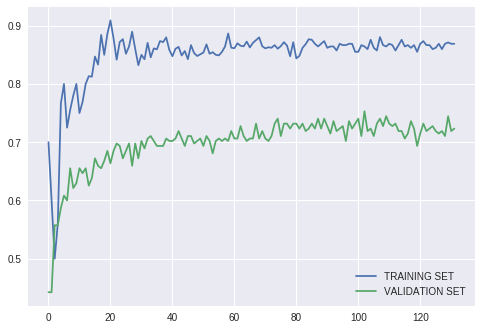

The accuracy is 0.723404255319149


In [0]:
learning_curves(model_rf, X_train, y_train)

## Gaussian Naive Bayes

### Fit

In [0]:
model_bn = GaussianNB()
model_bn.fit(X_train, y_train)

predictions_bn = model_bn.predict(X_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions_bn, y_test)))
print(confusion_matrix(predictions_bn, y_test))
tp, fp, fn, tn = confusion_matrix(predictions_bn, y_test).ravel()
print(f"tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}")
print(classification_report(y_test, predictions_bn))

Accuracy 64.54%
[[ 93  51]
 [ 77 140]]
tp: 93, fp: 51, fn: 77, tn: 140
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       170
           1       0.65      0.73      0.69       191

    accuracy                           0.65       361
   macro avg       0.65      0.64      0.64       361
weighted avg       0.65      0.65      0.64       361



### Learning curve


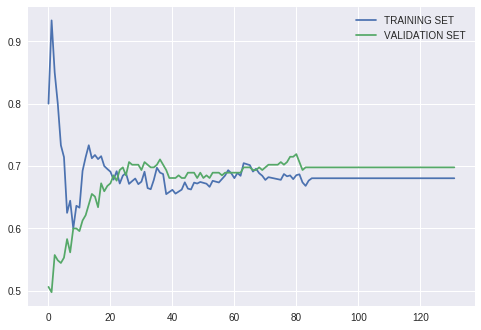

The accuracy is 0.6978723404255319


In [0]:
learning_curves(model_bn, X_train, y_train)

## KNN

### Hyperparameters optimization

In [0]:
hyper_knn = {'n_neighbors': [2, 3, 4, 5, 6],
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [0]:
gs = GridSearchCV(KNeighborsClassifier(), hyper_knn, cv=4, scoring='accuracy')
gs.fit(X_train, y_train)
best_parameters_knn = gs.best_params_
print(best_parameters_knn)

{'algorithm': 'auto', 'n_neighbors': 6}


###Fit

In [0]:
model_knn = KNeighborsClassifier(n_neighbors = best_parameters_knn['n_neighbors'],
                                 algorithm = best_parameters_knn['algorithm'])
model_knn.fit(X_train, y_train)

predictions_knn = model_knn.predict(X_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions_knn, y_test)))
print(confusion_matrix(predictions_knn, y_test))
tp, fp, fn, tn = confusion_matrix(predictions_knn, y_test).ravel()
print(f"tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}")
print(classification_report(y_test, predictions_knn))

Accuracy 62.05%
[[101  68]
 [ 69 123]]
tp: 101, fp: 68, fn: 69, tn: 123
              precision    recall  f1-score   support

           0       0.60      0.59      0.60       170
           1       0.64      0.64      0.64       191

    accuracy                           0.62       361
   macro avg       0.62      0.62      0.62       361
weighted avg       0.62      0.62      0.62       361



### Learning curve

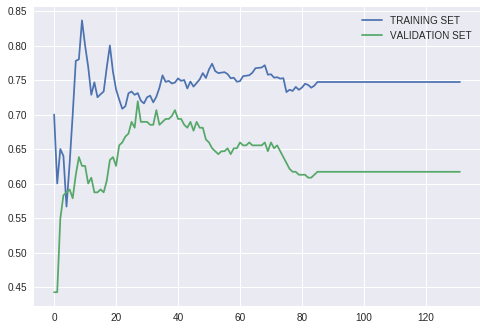

The accuracy is 0.6170212765957447


In [0]:
learning_curves(model_knn, X_train, y_train)

##Model Comparison

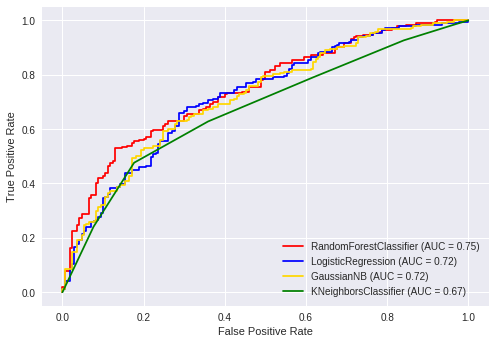

In [0]:
fig, ax = plt.subplots()

plot_roc_curve(model_rf, X_test, y_test, color = 'r', ax = ax)
plot_roc_curve(model_lr, X_test, y_test, color = 'b', ax = ax)
plot_roc_curve(model_bn, X_test, y_test, color = 'gold', ax = ax)
plot_roc_curve(model_knn, X_test, y_test, color = 'green', ax = ax)

## Ensemble

### Fit

In [0]:
ensemble = StackingClassifier(estimators = [('Random Forest', model_rf),
                                            ('Logistic Regression', model_lr),
                                            ('Naive Bayes', model_bn),
                                            ('KNN', model_knn)],
                              cv = 3,
                              final_estimator = model_lr)
ensemble.fit(X_train, y_train)

predictions_ensemble = ensemble.predict(X_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions_ensemble, y_test)))
print(confusion_matrix(predictions_ensemble, y_test))
tp, fp, fn, tn = confusion_matrix(predictions_ensemble, y_test).ravel()
print(f"tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}")
print(classification_report(y_test, predictions_ensemble))


Accuracy 68.98%
[[ 94  36]
 [ 76 155]]
tp: 94, fp: 36, fn: 76, tn: 155
              precision    recall  f1-score   support

           0       0.72      0.55      0.63       170
           1       0.67      0.81      0.73       191

    accuracy                           0.69       361
   macro avg       0.70      0.68      0.68       361
weighted avg       0.70      0.69      0.68       361



### Learning curve

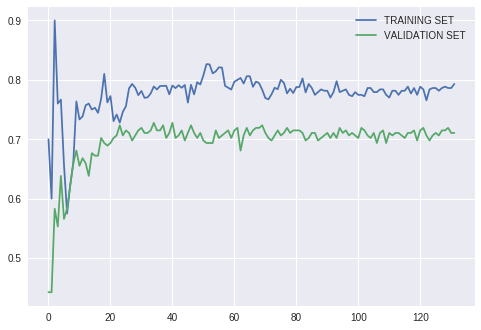

The accuracy is 0.7106382978723405


In [0]:
learning_curves(ensemble, X_train, y_train)

###ROC Curve

In [0]:
test = y_test.copy()
test = test.astype(int)

thresholds = [i for i in np.arange(0.5, 0.7, 0.01)]
tres = []
acc = []
pre = []

for t in thresholds:
    predicted = np.array(ensemble.predict_proba(np.array(X_test).reshape(-1, 4))[:, 0])
    predicted[predicted > t] = 1
    predicted[~(predicted > t)] = 0
    tres.append(t)
    acc.append(accuracy_score(test, predicted.astype(int)))
    pre.append(np.sum(test * predicted.astype(int)) / np.sum(predicted))

final_matrix = pd.DataFrame({'Threshold': tres,
                             'Accuracy': acc,
                             'Precision': pre})

In [0]:
final_matrix.head(50)

,Threshold,Accuracy,Precision
0,0.50,0.354571,0.338462
1,0.51,0.357341,0.330579
2,0.52,0.354571,0.322034
3,0.53,0.362881,0.330435
4,0.54,0.373961,0.339450
5,0.55,0.365651,0.310000
6,0.56,0.365651,0.306122
7,0.57,0.354571,0.271739
8,0.58,0.354571,0.266667
9,0.59,0.368421,0.282353


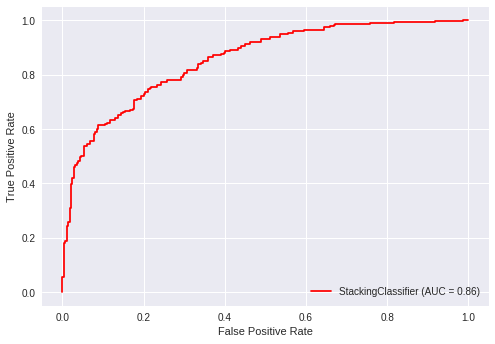

In [0]:
plot_roc_curve(ensemble, X_train, y_train, color = 'r')

#Save the model for later deploy with Python

In [0]:
import pickle
# save the model to disk
filename = 'Model_Ex_Post.sav'
pickle.dump(ensemble, open(filename, 'wb')) 

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

#Example of forecast with the model

In [0]:
# Let's consider an auction with the following features:
sconto = 0.64642099
offerta_minima = 27000
visite_dopo_7_gg = 132
ntn = 171
esito_prob = loaded_model.predict_proba(np.array([sconto,
                                                  np.log(offerta_minima),
                                                  np.log(visite_dopo_7_gg),
                                                  np.log(ntn)]).reshape(-1, 4))
print("Probability of the Auction to go:")
print("Deserta = {0:.2f}%".format(100*esito_prob[0][0]))
print("Aggiudicata = {0:.2f}%".format(100*esito_prob[0][1]))

Probability of the Auction to go:
Deserta = 23.87%
Aggiudicata = 76.13%
